In [1]:
 
import joblib
from vietocr.tool.config import Cfg
from vietocr.tool.predictor import Predictor
from modules.image_segmentation.predict import segment_single_images
import torch
from modules.text_clf.regex import date_finder
from modules.text_clf.phoBert import predict_phoBert
from modules.text_clf.svm import predict_svm
from PIL import Image
from modules.image_clf.predict import Predictor_image
from modules.text_detect.predict import test_net, net, refine_net, poly
import re
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
import argparse
from utils import rotate_box, align_box, get_idx
# from modules.text_recognition.predict import text_recognizer


The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [2]:

def test(image):
    image = segment_single_images(image)
    image_copy = image.copy()
    bboxes, polys, score_text = test_net(
        net, image_copy, 0.7, 0.4, 0.4, True, poly, refine_net)
    if bboxes != []:

        bboxes_xxyy = []
        ratios = []
        degrees = []
        for box in bboxes:
            x_min = min(box, key=lambda x: x[0])[0]
            x_max = max(box, key=lambda x: x[0])[0]
            y_min = min(box, key=lambda x: x[1])[1]
            y_max = max(box, key=lambda x: x[1])[1]
            if (x_max-x_min) > 20:
                ratio = (y_max-y_min)/(x_max-x_min)
                ratios.append(ratio)

        mean_ratio = np.mean(ratios)
        if mean_ratio >= 1:
            image, bboxes = rotate_box(image, bboxes, None, True, False)

        # if predict_image(image) == 1:
        #     image, bboxes = rotate_box(image, bboxes, None, False, True)

        bboxes, polys, score_text = test_net(
            net, image, 0.7, 0.4, 0.4, True, poly, refine_net)

        image, check = align_box(image, bboxes, skew_threshold=0.9)

        if check:
            bboxes, polys, score_text = test_net(
                net, image, 0.7, 0.4, 0.4, True, poly, refine_net)
        h, w, c = image.shape

        for box in bboxes:

            x_min = max(int(min(box, key=lambda x: x[0])[0]), 1)
            x_max = min(int(max(box, key=lambda x: x[0])[0]), w-1)
            y_min = max(int(min(box, key=lambda x: x[1])[1]), 3)
            y_max = min(int(max(box, key=lambda x: x[1])[1]), h-2)
            bboxes_xxyy.append([x_min-1, x_max, y_min-1, y_max])

        img_copy = image.copy()
        for b in bboxes_xxyy:
            cv2.rectangle(img_copy, (b[0], b[2]), (b[1], b[3]), (255, 0, 0), 1)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_copy)

        texts = []
        probs = []
        for box in bboxes_xxyy:
            x_min, x_max, y_min, y_max = box
            img = image[y_min:y_max, x_min:x_max, :]
            img = Image.fromarray(img)
            s, prob = text_recognizer.predict(img, return_prob=True)
            texts.append(s)
            probs.append(prob)
        print('text ', texts)
        plt.show()
        out, score = predict_svm(texts[10:])
        out_bert = predict_phoBert(texts[:10])

        rs_text = ""
        t_seller = None

        if len(np.where(out_bert == 0)[0]) != 0:
            seller_idx = np.where(out_bert == 0)[0][0].item()
            text_seller = texts[seller_idx]
            rs_text += text_seller+"|||"
        else:
            rs_text += "|||"
        if len(np.where(out_bert == 1)[0]) != 0:
            add_idx = np.where(out_bert == 1)[0]
            txt_address = ""
            for idx in range(len(add_idx)):
                txt_address += texts[add_idx[idx].item()]
                if idx < len(add_idx)-1:
                    txt_address += " "
            rs_text += txt_address + "|||"
        else:
            rs_text += "|||"
        date_str = None
        for idx, string in enumerate(texts):
            #                     if re.search("Ngày",string):
            #                         start_idx = re.search("Ngày",string).start()
            #                         date_str = string[start_idx:]
            if date_finder(string):
                date_str = string
                date_idx = idx
                if len(list(string)) > 30:
                    if re.search("Ngày", string):
                        start_idx = re.search("Ngày", string).start()
                        date_str = date_str[start_idx:]
        for idx, string in enumerate(texts):
            if re.search("Ngay", string):
                start_idx = re.search("Ngay", string).start()
                date_str = string[start_idx:]
        for idx, string in enumerate(texts):
            if re.search("Ngày", string):
                start_idx = re.search("Ngày", string).start()
                date_str = string[start_idx:]
        if date_str:

            rs_text += date_str+"|||"
        else:
            rs_text += "|||"

        cost_idx = get_idx(out, score, 0)

        if cost_idx != None:
            txt_cst = texts[cost_idx]
            rs_text += txt_cst

            cst1_xmin, cst1_xmax, cst1_ymin, cst1_ymax = bboxes_xxyy[cost_idx]
            cst1_ycenter = (cst1_ymin+cst1_ymax)/2

            for box in bboxes_xxyy:
                if box == bboxes_xxyy[cost_idx]:
                    continue
                x_min, x_max, y_min, y_max = box
                if abs(cst1_ycenter-(y_max+y_min)/2) < 13:
                    img = image[y_min:y_max, x_min:x_max, :]
                    img = Image.fromarray(img)
                    s, prob = text_recognizer.predict(img, return_prob=True)
                    rs_text += " " + s
        inp_task1 = []
        for prob in probs:
            if np.isnan(prob):
                continue
            inp_task1.append(prob)
        inp_task1 = sorted(inp_task1)
        if len(inp_task1) > 100:
            inp1 = np.array(inp_task1[:100])
        else:
            inp1 = np.concatenate((inp_task1, np.zeros(
                100 - len(inp_task1), dtype=np.float32)))

        out_task1 = model_task1.predict([inp1])
        out_task1 = out_task1.item()
    else:
        out_task1 = 0.2
        rs_text = "|||||||||"
    return rs_text, out_task1



Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


10


/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['Guitar Cafe', 'ITel. 098 526 8359', '28 Phan Chu Trinh, Hiệp Phú, Quận 9, Hồ', 'Ngày lập: 02/10/2020', 'Khu vực: Tâng trệt', 'Hóa đơn: HDL201002-0013', 'Bàn: S13', 'PHIẾU TÌNH', 'TIEN', 'Số lượng', 'Tiền', 'Món', 'Đơn giá', 'Café (nóng/ dá) - Ly', '25,000', '25,000', '2', 'Cơm phần - Phần', '60,000', '60,000', '1', '1', 'Thành tiên: 85,000', 'Cám ơn quý khách, hẹn gàp lại']


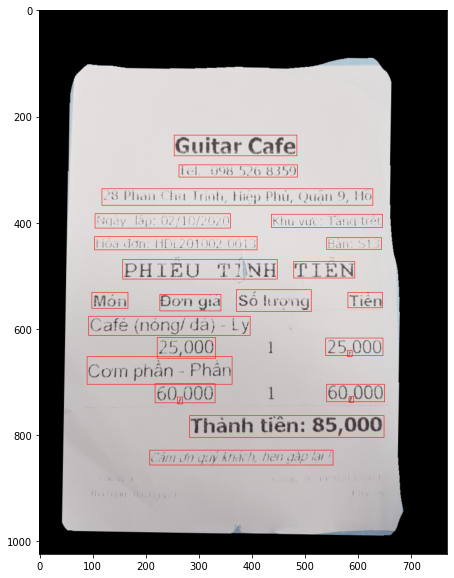

/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['TẠP HÓA PHƯƠNG ANH', 'Đ/c: Xóm 2 Thọ Bình - Tân Dân', 'Khoái Châu - Hưng Yên', '036.6815.960', 'HÓA ĐƠN BÁN HÀNG', 'Số: 190000002', 'Ngày 11/05/19', 'Thu ngân: Administrator', 'In lúc: 16:55', 'Khách hàng:', 'T. Tiền', 'SL', 'Mặt hàng', '350,000', 'Xúc xích phô mai', '7', '7', 'Tổng SL:', '350,000', 'Tổng:', '400,000', 'Khách đưa:', '50,000', 'Trả lại:', 'Xin cảm ơn Quý khách/ Thank youl (s']


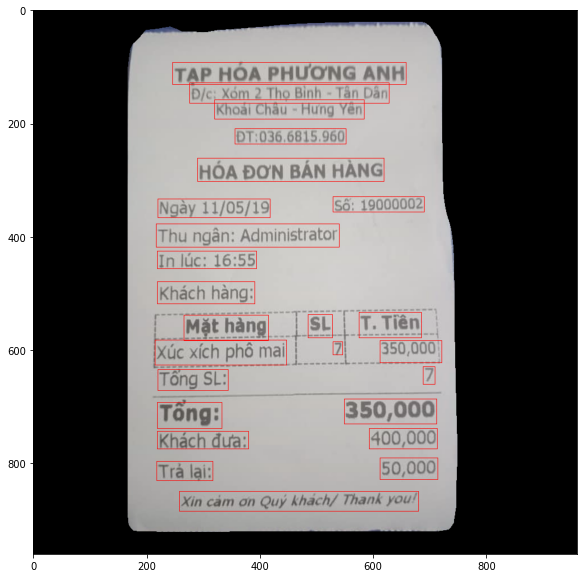

/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['BIDA TÂN AN PHÁT', '1925/15 Âu Cơ, Tân Sơn Nhì, Tân Phú Nha', '19 Tel: (08) 6.684 1111 - 0967 04 11111 1991', 'Phiếu Thanh Toán Trị', 'Bản:', 'Số phiếu: 980', 'T3', 'Ngày: 18/05 15:50-15:51', 'P.Vụ:', 'Tên hàng', 'Đơn giáo', 'Thành tiền', 'SL Đvt', 'cà phế đá', '20,000 -', '20,000', 'ly', 'ly', 'cà phê sữa đá', '30,000', '30,000', 'TỜ', 'AN GIANG', '10,000 -', '10,000', 'SINH TỔ BƠN', 'LY', '12,000 số', '12,000', 'SINH TỐ SAPOECH', 'LY', '25,000 ?', '25,000', 'SINH TỔ DỬA', 'LY', '30,000', '30,000', 'Số tiền', '127,000', 'Cộng phí phục vụ 10%:', '139,700', 'LL-ZALO. min bây trăm đông', 'có hẹn gặp lạil', 'Paswifi: 12345789']


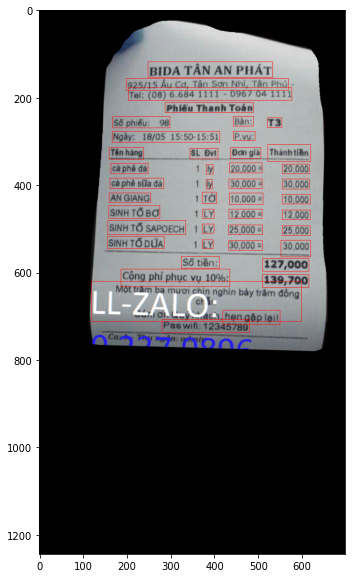

/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['MINIMART ANAN', 'Và Chợ Sủi Phú Thị Gia Lâm Đó', 'tel:', 'HÓA ĐƠN BÁN HÀNG', 'Đơn giá Thành tiến', 'Tên hàng', 'SL ĐVT', '8934673402323 SCU susu cam VNM 110ml NT', 'Giá đăng ký:', '4,500', 'Giá bán:', 'HOP', '4,000', '32,000', '8934673319324 SCU susu táo nho hộp 110ml No', 'Giá đăng ký', '4,500', 'Giá bán:', '4,000', '16,000', 'HOP', '8934673401326 SCU susu dâu VNM 110ml NT', '4,500', 'Giá đăng ký:', '4,000', 'Giá bán:', 'HOP', '16,000', '5', '8934760211920 Bánh tipo túi 220g NT', '27,000', 'HOP', '27,000', '8934680042888 Bánh Solite dâu, dứa cuộn K NT', '36,000', 'HOP', '36,000', '8935265210029 bánh trứng mềm belgi túi 24 NT', '24,000', 'GOI', '24,000', 'Tổng số:', '19', '151,000', 'Tổng cộng', '151,000', 'TENG TIÊN', '151,000', 'Tiền khách trá: 1', 'VNDS']


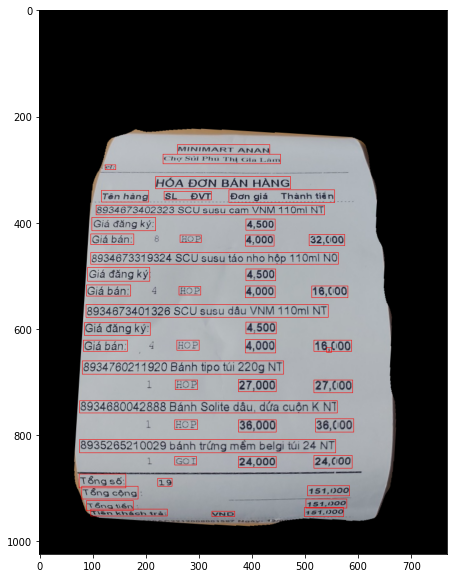

/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['MINIMART ANANT', 'Chợ Sủi Phú Thị Gia Lâm', 'Tel:', 'HÓA ĐƠN BÁN HÀNG', 'Thành tiền', 'Đơn giá', 'ĐVT', 'SL', 'Tên hàng', '8934561 020035 Phở vifon bò NT', '5,500', 'Giá đăng ký:', '51,000', '5,100', '1 0', 'GOI', 'Giá bán:', '29103989000 mì kokomi mì 90 NO', '3,500', 'Giá đăng ký:', '95,010', '3,167', 'Giá bán:', 'goil', '30', 'Tổng số:', '40', '146,010', 'Tổng cộng:', '146,010', 'Tổng tiền', 'Tiền khách trả:', '500,000', 'VND', 'Tiền trả lại VND:', '353,990', 'Mã thẻ: A1000000000694', '(0) nguyễn thị thảo', 'Điêm mua:', '14', 'Điểm hiện thời:', '816', 'Hạng hiện thời:', 'Giá trị thưởng tích lũy:', '34,000', 'Số GD: 000AC2212008001818 Ngày: 13/08/2020-17:52', 'Thu ngân: BH3', 'Xin cám ơn và hẹn gặp lại quý khách l']


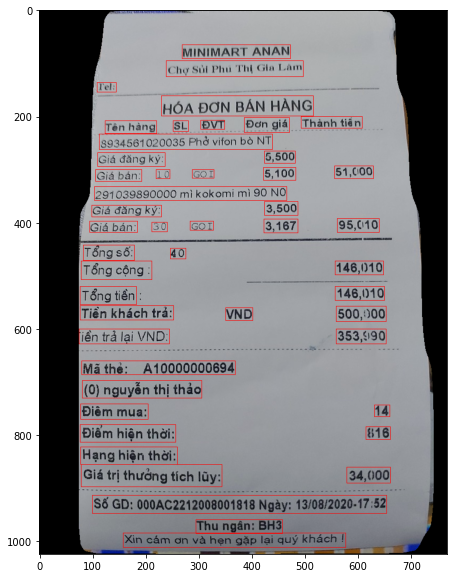

/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['In the coffee house', '403 Phan Huy Ich, P.14, Q.Gò Vấp', 'Số:', '27', 'Thời gian:30.09.2020 08.08 Số HĐ: 19809052972020', 'Thu ngân: cash1', 'Khách hàng:', 'Tên món', 'SL', 'Đ.Giá', 'T.Tiền', '1 Bánh Mì Que Cay', '10 000', '40 000', 'Thành tiên:', '40 000', 'Thanh Toán:', '40 000', 'Tiên khách dưa:', '40000', 'Tiền thừa', '0', '% Tiền mặt VND', '40 000']


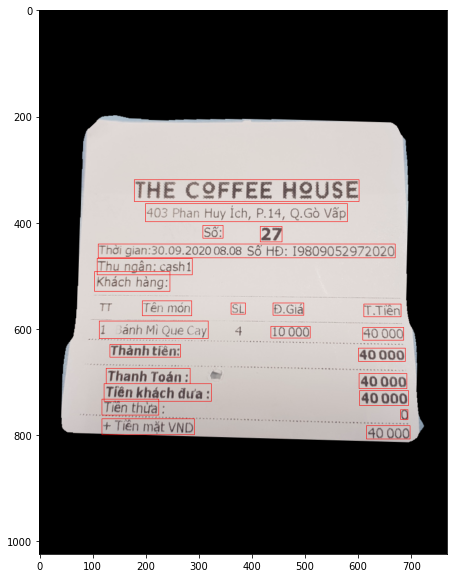

/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['FamilyMart', '213 Nguyễn Văn Cừ, P.4, Q.5', 'Tel3 184-8-3300745 Fax: 184-8-38300745', 'HÓA ĐƠN BẢN HÀNG (01/02)', 'Số HĐ: 002170714104221', 'Tên hàng', 'Đơn giá Thành tiền', 'SL', '1122 Bản tưới Nguyễn', '4.000', '4,000', '2T2.Combo 2.0', '23,000', '23.000', '2,000', 'Giảm glá /mặt hàng:', 'Tổng số:', '2', 'Tổng cộng:', '27,000', 'Tổng chiết khău;', '2,000', 'Transfirm', '25,000', 'Tiền khách trả:', 'CASH VND', '50,000', 'Tiền thối lại VND:', '25,000', 'Xin cám ơn quý khách I', 'Thu ngân: 000', 'Ngày: 14/07/2017 - Giờ 10:42', 'Hóa đơn bán hàng chỉ có giá trị khi quý khách yêu cầu', 'xuất hóa đơn GTếT trong ngày, Hóa đơn sẽ được cung', 'cấp trong vòng 10 ngày.', 'VATinvoice shall be available within 10 days, only if you', 'ask ourstaff for the issuance TODAY No INVOICE shall', 'askssurst for the request after the following day of', 'purchase.', 'HÃY MUA NGAY SẢN PHẢM', 'THUỘC CHƯƠNG TRÌNH', 'Spider-Man "": Homecoming', 'Đề có có cơ hội sở thừu những phần quả hấp dẫn nhạt', 'cơ h

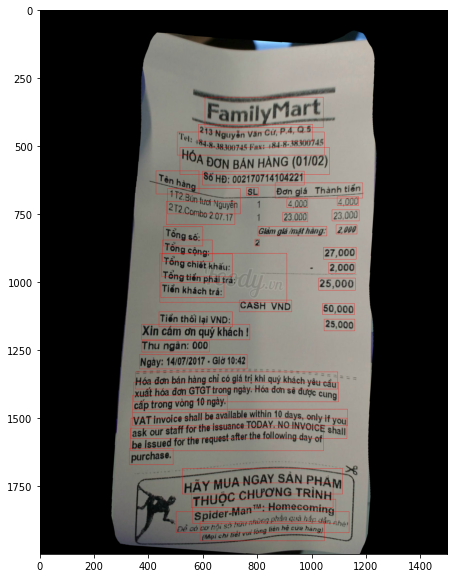

/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['Unporting', 'Coffee Kem Sen Trắng', 'Đường Số 2 - KDC 135 - TT. Bến Lức', 'HÓA ĐƠN THANH TOÁN', '0006', 'HĐ', '12:24:54', '13/09/2017 Giờ:', 'Ngày', 'A 1', 'BÀN:', 'T.TIÊN', 'Đ.GIÁ', 'SL', 'TÊN HÀNG', '25,000', '25,000', 'Yaourt Nha Đam 1', '20,000', '20,000', 'Chanh Dây', '22,000', '22,000', 'Kem Socola', '22,000', '22,000', 'Kem Vanila', '22,000', '22,000', 'Kem Sầu Riêng', '22,000', '22,000', 'Kem Dừa', '28,000', '28,000', 'Nước Ép Ói', '28,000', '28,000', '- Nước Ép Thơm Là', 'Dừa', '189,000', 'T.CỘNG', 'GIẢM % HĐ (-20%)', '37,800', 'TIỀN MẶT', '151,200', 'Một trăm năm mươi mốt ngàn hai trăm', 'đồng./']


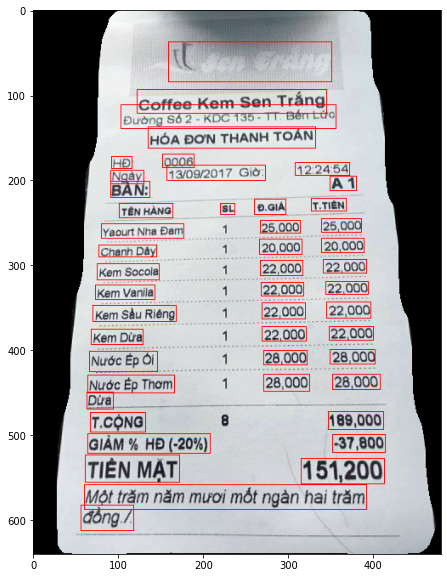

/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['MINIMARTANAN', 'Chợ Sủi Phú Thị Gia Lâm', 'Tel:', 'HÓA ĐƠN BÁN HÀNG', 'Thành tiền', 'ĐVF', 'Đơn giá', 'Tên hàng', 'Sb', '391009670000 Bánh mì tươi sữa và siêu mề NT', '12,000', '6,000', 'CAI', '2', '291022440000-bánh mìnhokđ NT Tháng', '9,000', '4,500', '2', 'CAI', '291001560000 Xúa xích Bông mai 115g NT', '9,000', '9,000', 'GỌI', '291005380000 Mirchính ajinomoto 1kg NT', '62,000', '62,000', 'GOI', 'Tổng số:', '92,000', 'Tổng cộng:', 'Tiền khách trả:', 'VND', '92,000', '001000001478', 'Mã thẻ:', '(0) nguyễn thị huyền', 'Điêm mua:', '9', 'Điểm hiện thời:', '2,910', 'Hạng hiện thời:', '6,639', 'Giá trị thưởng tích lũy:', 'Số GD: 000AB2212008003194 Ngày: 13/08/2020-08:47', '- Thu ngân: BH2', 'Xin cam an và hẹn gập lại quý khách I']


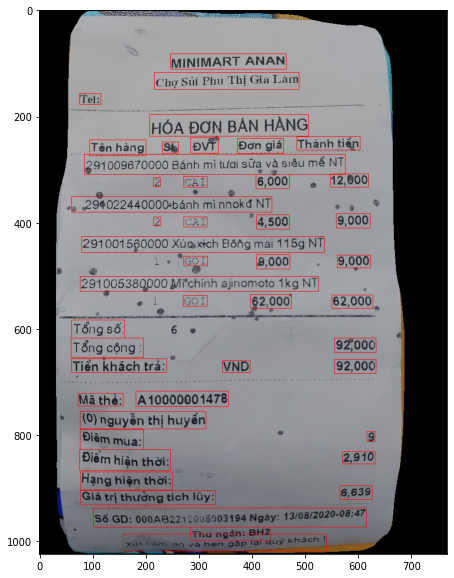

/home/it/Data/thaiphData/Vietnamese-ocr/project/modules/text_detect/modules_craft.py:448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
<ipython-input-2-08c54ab532da>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes != []:


text  ['jeeanstore', '1980 Địa chỉ: 430 Xã Đàn - Quận Đồng Đa, Hà Nội Nội Nội', 'Điện thoại:', 'HÓA ĐƠN BẢN HÀNG', 'SỐ HĐ: HD000003', 'Ngày 17 tháng 07 năm 2020', 'Thời Khách hàng: Tàn Phát mà vạch thán', 'SĐT: 02435666555', 'Thời Địa chỉ: 430 Xã Đàn - Phường Nam Đồng - Quận Thuận', 'Đồng Đa, Hà Nội', 'Đơn giá', 'Thành tiền', 'Giầy Lacoste', '760,000', '760,000', 'Sơ mi Luisvuiton', '280,000', '280,000', '2000 san điều phát', '430,000', '430,000', 'Quần Jean DaGa', '370,000', '370,000', '- Tổng tiền hàng:', '1,840,000', 'Chiết khấu', 'Tổng thanh toán: hà', '1,840,000', 'Trong (Một triệu tám trăm bốn mươi nghìn đồng chắn)', "Cảm on và hẹn gặp lại' trị"]


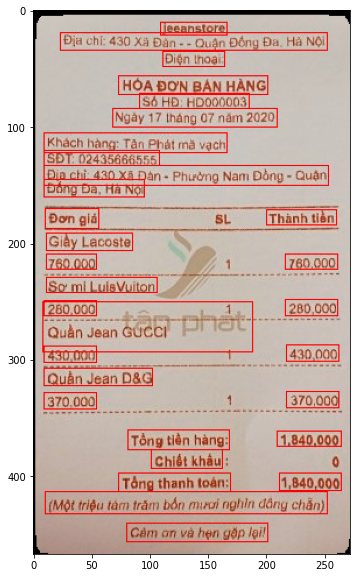

In [3]:

if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # parser = argparse.ArgumentParser(description='MC-OCR inference')
    # parser.add_argument('--folder_test', type=str, help='path to folder')
    # args = parser.parse_args()
    path = '../datatest/test1'

    predict_svm = predict_svm()
    predict_phoBert = predict_phoBert()
    # predict_image = Predictor_image()
    # recognition
    config = Cfg.load_config_from_name('vgg_transformer')
    config['weights'] = 'weights/transformerocr.pth'
    config['cnn']['pretrained'] = False
    config['device'] = 'cuda:0'
    config['predictor']['beamsearch'] = False
    text_recognizer = Predictor(config)
    model_task1 = joblib.load("weights/model_task1.sav")
    with open('results.csv', mode='w') as csv_file:
        fieldnames = ['img_id', 'anno_image_quality', 'anno_texts']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

        writer.writeheader()
        print(len(os.listdir(path)))
        for file_name in os.listdir(path):
            image = cv2.imread(os.path.join(path, file_name))
            rs_text, out_task1 = test(image)
            writer.writerow(
                {'img_id': file_name, 'anno_image_quality': out_task1, 'anno_texts': rs_text})
